# EEG Preprocessing using independent component analysis (ICA)
ICA can be used for artefact detection, since it identifies seperate components of the signal that have been combined during recording. That means that we can actually separate noise compoenents, such as eye blinks, from the rest of the signal, and thereby exclude them.

**Notes:**
* add trigger for mouse-click
* add trigger for maximal decelaration in incongruent trials
    * find this in R using mousetrap package?
* remove data after experiment finished?
    * determine length of experiment from behavioural data
* Do we filter before doing ICA - yes according to first link below! 


NICE LINKS:https://erpinfo.org/blog/2018/6/18/hints-for-using-ica-for-artifact-correction & https://labeling.ucsd.edu/tutorial/labels

## Loading modules & data

In [130]:
# importing modules
import numpy as np
import mne
import pandas as pd
#! pip install mne

In [131]:
raw = mne.io.read_raw_brainvision('Stroop_mouse_EEG_data/EEG/Group7_own.vhdr', eog=('EOG1', 'EOG2'), preload = True)

Extracting parameters from Stroop_mouse_EEG_data/EEG/Group7_own.vhdr...
Setting channel info structure...
Reading 0 ... 487319  =      0.000 ...   487.319 secs...


### Removing EEG data which was recorded before and after the experiment
**Note:** Figure out when this was

In [132]:
raw.crop(tmin=0.0, tmax=410, include_tmax=True)

<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

### Specifing the channel locations using the montage-related functions

In [133]:
montage = mne.channels.make_standard_montage('standard_1020') 
raw.set_montage(montage, verbose=False)

<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

## Redefine the reference to a common average

In [134]:
raw.set_eeg_reference('average', projection=False, verbose=False)

<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

## Preparing data for ICA
High-pass filtering the data at 0.1 Hz and subsequently low-pass filtering at 40 Hz

In [135]:
raw = raw.filter(0.1, None)
raw = raw.filter(None, 40)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 33001 samples (33.001 sec)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 sec)



## Setting up and fitting the ICA
Fitting the ICA with 800 iterations with a random seed at 97. n_components=0.95 ensures that the number of components selected explain at least 95% of the variance in the data

In [136]:
ica = mne.preprocessing.ICA(n_components=0.95, random_state=97, max_iter=800)
ica.fit(raw)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 63.6s.


Method,fastica
Fit,444 iterations on raw data (410001 samples)
ICA components,17
Explained variance,95.7 %
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


## Plotting of ICA
### Plotting of components

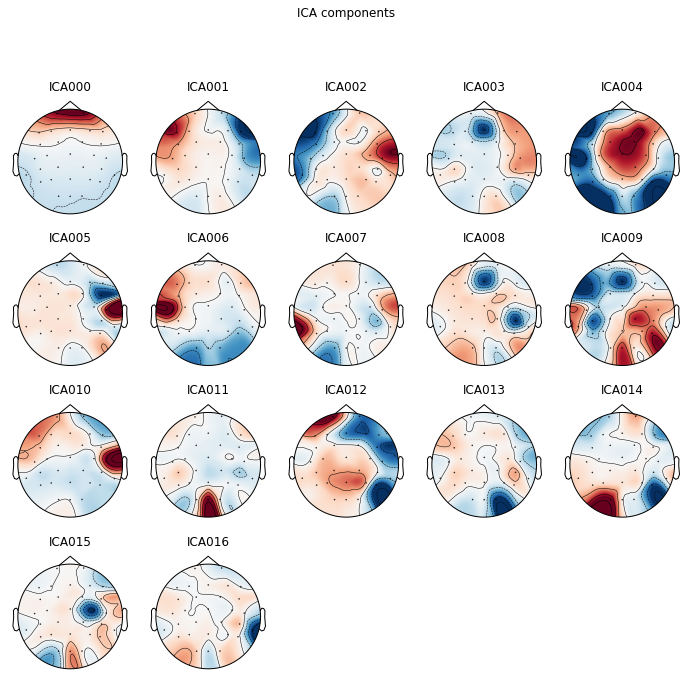

In [137]:
ica.plot_components();

### Plotting of the time series of the ICA

Creating RawArray with float64 data, n_channels=19, n_times=410001
    Range : 0 ... 410000 =      0.000 ...   410.000 secs
Ready.
Using matplotlib as 2D backend.


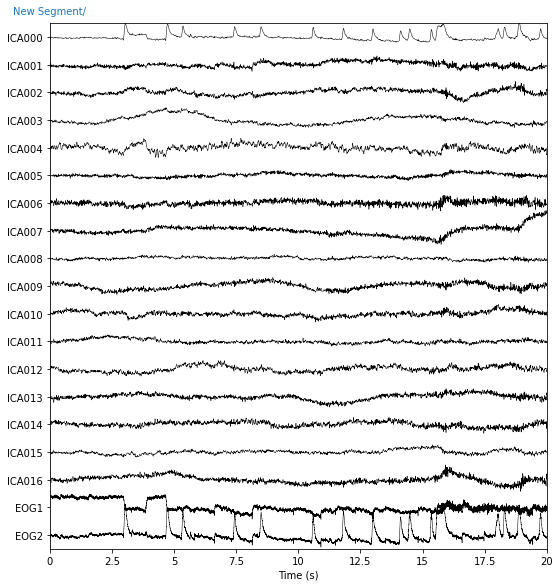

In [138]:
ica.plot_sources(raw, show_scrollbars=False);

## Exclusion of components
From visual inspection of the topographic maps and the time series plots of the components, we can see that the ____  component seems to capture noise especially from eyeblinks. Consequently, we can remove it and thereby extract these artefacts from the data.


**Note:** Figure out which components to remove


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
205 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


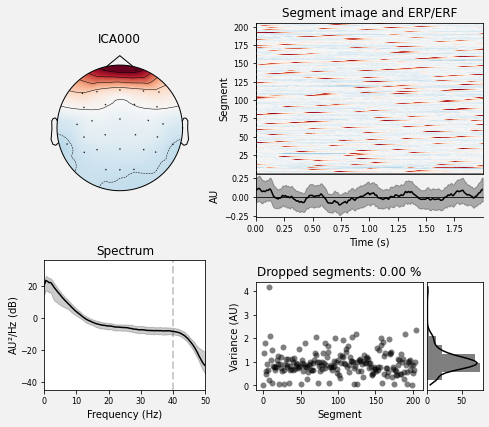

In [139]:
# the second component is excluded based on visual inspection
ica.exclude = [0]
ica.plot_properties(raw, picks=ica.exclude);

## Applying ICA to the data

In [140]:
ica.apply(raw)

Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 1 ICA component
    Projecting back using 30 PCA components


<RawBrainVision | Group7_own.eeg, 32 x 410001 (410.0 s), ~100.1 MB, data loaded>

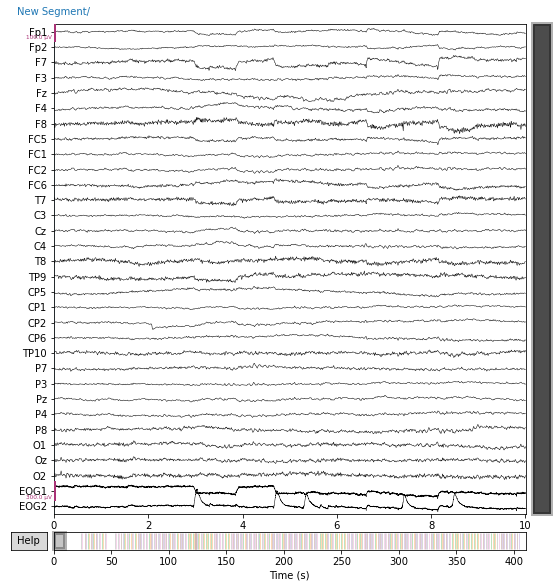

In [141]:
# plotting the data after ICA
raw.plot(n_channels = 33, scalings = {'eeg': 50e-6});

### Epoching the data
Using the `events_from_annotations` function an array of the events is extracted. The first column is the time stamp in samples, and the third column contains the event id.

In [174]:
events, _  = mne.events_from_annotations(raw)

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 31', 'Stimulus/S 32']


#### Deleting triggers from practise trials

In [175]:
events = np.delete(events, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18], 0) # Delete the 18 first events which are practise trials

#### Adding triggers for maximum deceleration
This is done by importing some data extracted from the mousetracking data in R using the `mousetrap` package. 


TODO:
* **Find out which variable** does not seem to be the right one at least

In [176]:
# Loading in csv with info
mouse_df = pd.read_csv('Stroop_mouse_EEG_data/additional_triggers.csv')
mouse_df.head()

,trial_number,acc_min_time,acc_max_time,onset_image,time_clicked
0,1,0.733350,0.650132,31.300117,32.205129
1,2,0.622053,0.605359,33.730150,35.321251
2,5,0.655069,0.555022,41.664691,42.371758
3,7,0.904982,0.721573,46.230187,47.171998
4,11,0.620760,0.570678,55.515457,56.288778


##### Aligning timing from behavioural data with EEG


In [177]:
# Determining timing for display of first image in EEG (measured in samples)
sample_time_first_image = events[1][0]          # one since first trigger is when the recording started

# Sampling rate
sampling_rate_eeg = 1000/1                      # 1000 Hz

# Timing for display of first images in mousetracking (measured in seconds)
mouse_first_img_display = mouse_df.iloc[0,3]

In [178]:
# determining after how many samples the largest deaccelaration occured FIX NOT WHAT IS DONE NOW
mouse_df['st_acc_max'] = (mouse_df['onset_image'] - mouse_first_img_display + mouse_df['acc_min_time']) * sampling_rate_eeg + sample_time_first_image

# making it into integer since trials can only be whole numbers
mouse_df['st_acc_max'] = mouse_df['st_acc_max'].astype(int)

Now an array is created with these additional triggers

In [179]:
for i in range(len(mouse_df)): 
    new_array = [[mouse_df['st_acc_max'][i], 0, 33]]
    events = np.append(events, new_array, axis = 0)

In [180]:
# Determining all the unique triggers
np.unique(events[:,2])

array([   11,    12,    21,    22,    31,    32,    33, 99999])

In [181]:
# Creating a dictionary with event ids
event_id = {'Image/cNeu': 11, # Image trigger neutral condition 
            'Image/cCon': 21, # Image trigger congruent condition  
            'Image/cInc': 31, # Image trigger incongruent condition 
            'Word/cNeu': 12, # Word trigger neutral condition
            'Word/cCon': 22, # Word trigger congruent condition
            'Word/cInc': 32, # Word trigger incongruent condition
            'DeAcc/cInc': 33 # Word trigger incongruent conditionn
} 

/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_31299/3511924737.py:1: RuntimeWarning: event 99999 missing from event_id will be ignored
  mne.viz.plot_events(events, first_samp=raw.first_samp, event_id=event_id);


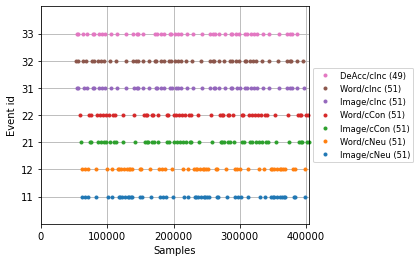

In [182]:
mne.viz.plot_events(events, first_samp=raw.first_samp, event_id=event_id);

**Note:** Determine sensible time window

In [183]:
# establishing time window
tmin, tmax = -0.2, 0.5

In [184]:
# rejecting all epochs with values exeeding 150 micro volts - cannot be brain data
reject = {'eeg': 150e-6}

In [185]:
# choosing only EEG channels for epoching
picks = mne.pick_types(raw.info, eeg=True, eog=False)

In [186]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=(None, 0), reject=reject, preload=True, verbose = True)

Not setting metadata
Not setting metadata
355 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 355 events and 701 original time points ...
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['C4']
    Rejecting  epoch based on EEG : ['FC5']
    Rejecting  epoch based on EEG : ['FC5']


/var/folders/4t/gp67d4t56ysgr041byyd6shr0000gn/T/ipykernel_31299/2328976030.py:4: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,


    Rejecting  epoch based on EEG : ['FC5']
5 bad epochs dropped


In [187]:
# Downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

### Plot of consistency of participant’s brain responses as measured at Oz to all the words and to all the images

In [188]:
img_epochs = epochs_resampled['Image']
word_epochs = epochs_resampled['Word']
img_neu_epochs = epochs_resampled['Image/cNeu']
img_con_epochs = epochs_resampled['Image/cCon']
img_inc_epochs = epochs_resampled['Image/cInc']
dec_inc_epochs = epochs_resampled['DeAcc/cInc']

Not setting metadata
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


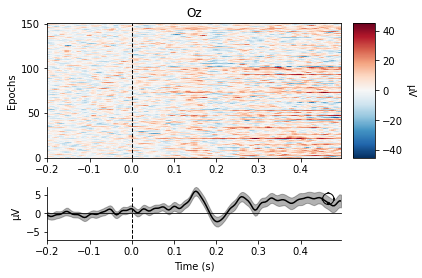

Not setting metadata
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


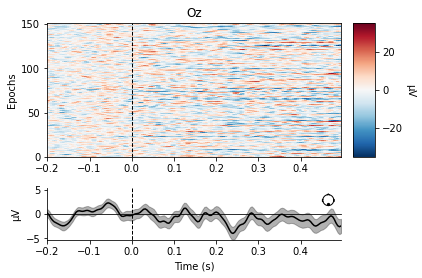

In [189]:
# plotting one channel as an example for each modality
# now the '/' used in the event IDs comes in handy! To get all epochs with image stimuli, we can index 'image' across the left/right dimension 
img_epochs.plot_image(picks=['Oz']);
word_epochs.plot_image(picks=['Oz']);

### Global field power
Looking a bit closer at the averaged responses, here visualized with the gfp (global field power).

GFP is actually the same as taking the standard deviation across all channels in each time sample. This tells us in which timepoints we see the biggest difference between different channels, which in turn is indicative of some kind of (more or less) focal activity.

#### Image GFP's

In [190]:
image_evoked = img_epochs.average()
image_inc_evoked = img_inc_epochs.average()
image_con_evoked = img_con_epochs.average()
image_neu_evoked = img_neu_epochs.average()

combining channels using "gfp"


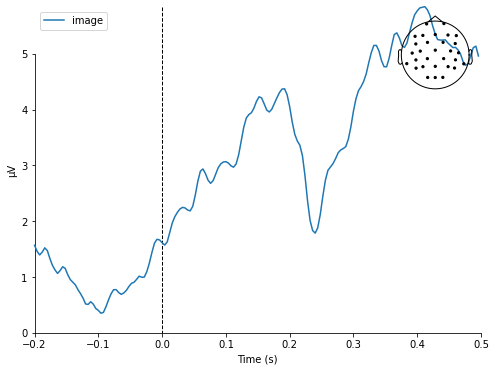

[<Figure size 576x432 with 2 Axes>]

In [191]:
mne.viz.plot_compare_evokeds({'image': image_evoked},
                             legend='upper left', show_sensors='upper right')

Above we see the evoked response for with the presentation of the image stimuli at time = 0. 

##### GFP for different conditions

combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


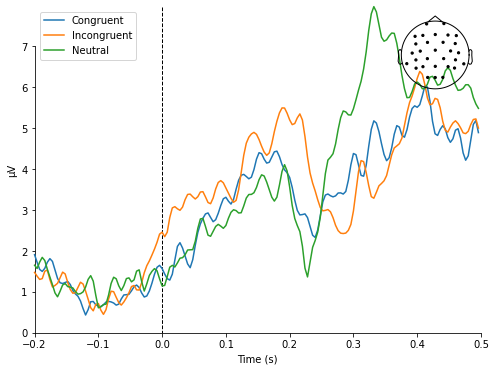

[<Figure size 576x432 with 2 Axes>]

In [192]:
mne.viz.plot_compare_evokeds({'Congruent': image_con_evoked,
                              'Incongruent': image_inc_evoked,
                              'Neutral': image_neu_evoked},
                             legend='upper left', show_sensors='upper right')

#### GFP incongrunent condition timelocked to maximum deceleration

In [193]:
decelaration_evoked_inc = dec_inc_epochs.average()

combining channels using "gfp"


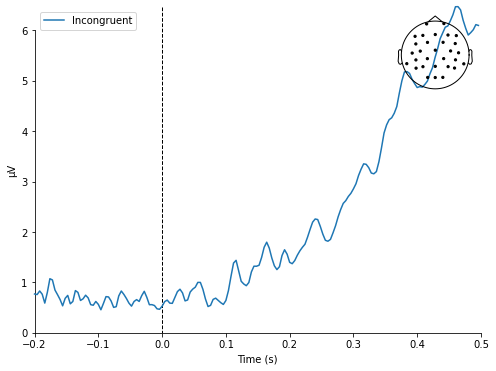

[<Figure size 576x432 with 2 Axes>]

In [194]:
mne.viz.plot_compare_evokeds({'Incongruent': decelaration_evoked_inc},
                             legend='upper left', show_sensors='upper right')

No projector specified for this dataset. Please consider the method self.add_proj.


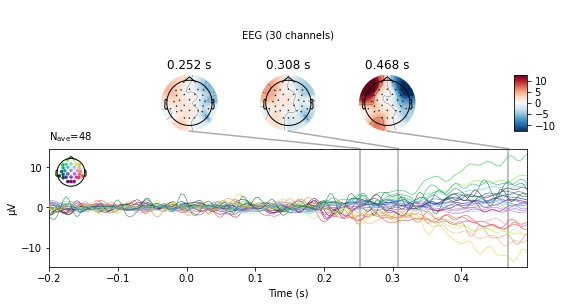

In [168]:
decelaration_evoked_inc.plot_joint(picks='eeg');

#### Components
**N170 component:** Showing visual stimuli one would expect to find the N170 component. 

**P3 component:** decision making component
* Is this maybe why we see the rise towards the end again?"
* "More specifically, the P300 is thought to reflect processes involved in stimulus evaluation or categorization."
* "The signal is typically measured most strongly by the electrodes covering the parietal lobe. The presence, magnitude, topography and timing of this signal are often used as metrics of cognitive function in decision-making processes. While the neural substrates of this ERP component still remain hazy, the reproducibility and ubiquity of this signal makes it a common choice for psychological tests in both the clinic and laboratory."

**P3a component:**
* "The P3a is a positive-going scalp-recorded brain potential that has a maximum amplitude over frontal/central electrode sites with a peak latency falling in the range of 250–280 ms. The P3a has been associated with brain activity related to the engagement of attention (especially orienting and involuntary shifts to changes in the environment) and the processing of novelty" (is this what we are looking for???)

**P3b component:**
* Generally speaking, improbable events will elicit a P3b, and the less probable the event, the larger the P3b (so i guess we are more interested in P3a?)


No projector specified for this dataset. Please consider the method self.add_proj.


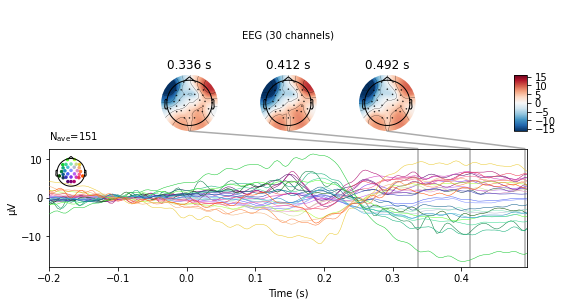

In [161]:
image_evoked.plot_joint(picks='eeg');

No projector specified for this dataset. Please consider the method self.add_proj.


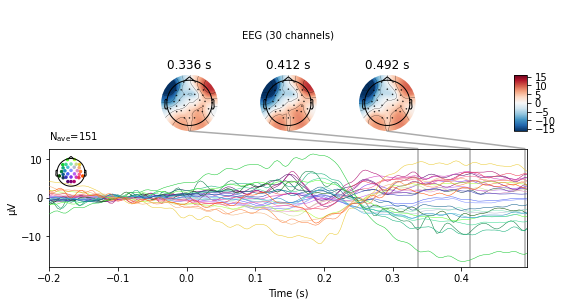

In [162]:
image_evoked.plot_joint(picks='eeg');